# Imports

In [313]:
# imports
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor, Pool, CatBoostClassifier
from sklearn.metrics import r2_score, accuracy_score
import seaborn as sns
from sklearn.model_selection import train_test_split 
import math
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle

# opcje:
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', 60)
pd.set_option('display.max_columns', None)

## Preparing datsets




In [314]:
# Train
train = pd.read_csv(
    '/Users/alexdrozdz/JupyterNotebook/New_York_City_Taxis/train_processed.csv', 
    index_col=0)

In [315]:
train = train.reindex(
    sorted(train.columns), axis=1)

In [316]:
train = shuffle(train)

In [317]:
test = pd.read_csv(
    '/Users/alexdrozdz/JupyterNotebook/New_York_City_Taxis/test_processed.csv', 
    index_col=0)

In [318]:
test = test.reindex(
    sorted(test.columns), axis=1)

## CatBoost

In [336]:
X = train

In [337]:
y = np.log1p(X['trip_duration'])

In [338]:
X = X.drop('trip_duration', axis = 1)
X = X.drop('id', axis = 1)

In [339]:
X = X.astype('float64')

In [340]:
cols = X.columns

In [341]:
X.shape

(1429538, 41)

In [342]:
X = X.to_numpy()
y = y.to_numpy()

### Training

In [343]:
CatTaxi = CatBoostRegressor(iterations=1000,
                            metric_period=250,
                            depth=10,
                            l2_leaf_reg = 0.01,
                            loss_function='MAE',
                            bootstrap_type='MVS',
                            boost_from_average=True,
                            grow_policy='Depthwise'
                            )

In [344]:
CatTaxi.fit(X, y)

0:	learn: 0.5524103	total: 971ms	remaining: 16m 9s
250:	learn: 0.2335969	total: 4m 23s	remaining: 13m 5s
500:	learn: 0.2215869	total: 8m 22s	remaining: 8m 20s
750:	learn: 0.2136514	total: 12m 45s	remaining: 4m 13s
999:	learn: 0.2077604	total: 19m 53s	remaining: 0us


In [345]:
def plot_importance(catboost_model, column_names):
    """
    Function created for cotboost models to visualize feature importance. 
    It shows 20 most important features.
    """
    important_df = pd.DataFrame()
    important_df['feature'] = column_names
    important_df['importance'] = catboost_model.get_feature_importance()
    df_to_plot = important_df.sort_values(
        by='importance', 
        ascending=False).reset_index(drop=True).head(20)
    fig = plt.figure(figsize=(17,15))
    axes = fig.subplots(ncols=1, nrows=4, sharey=True)
    sns.barplot(df_to_plot['feature'][0:5],
                df_to_plot['importance'][0:5], ax=axes[0])
    sns.barplot(df_to_plot['feature'][5:10],
                df_to_plot['importance'][5:10], ax=axes[1])
    sns.barplot(df_to_plot['feature'][10:15],
                df_to_plot['importance'][10:15], ax=axes[2])
    sns.barplot(df_to_plot['feature'][15:20],
                df_to_plot['importance'][15:20], ax=axes[3])
    for ax in axes:
        for p in ax.patches:
            ax.annotate(str(round(p.get_height(),2)), 
                        (p.get_x() * 1.005, p.get_height() * 1.01))

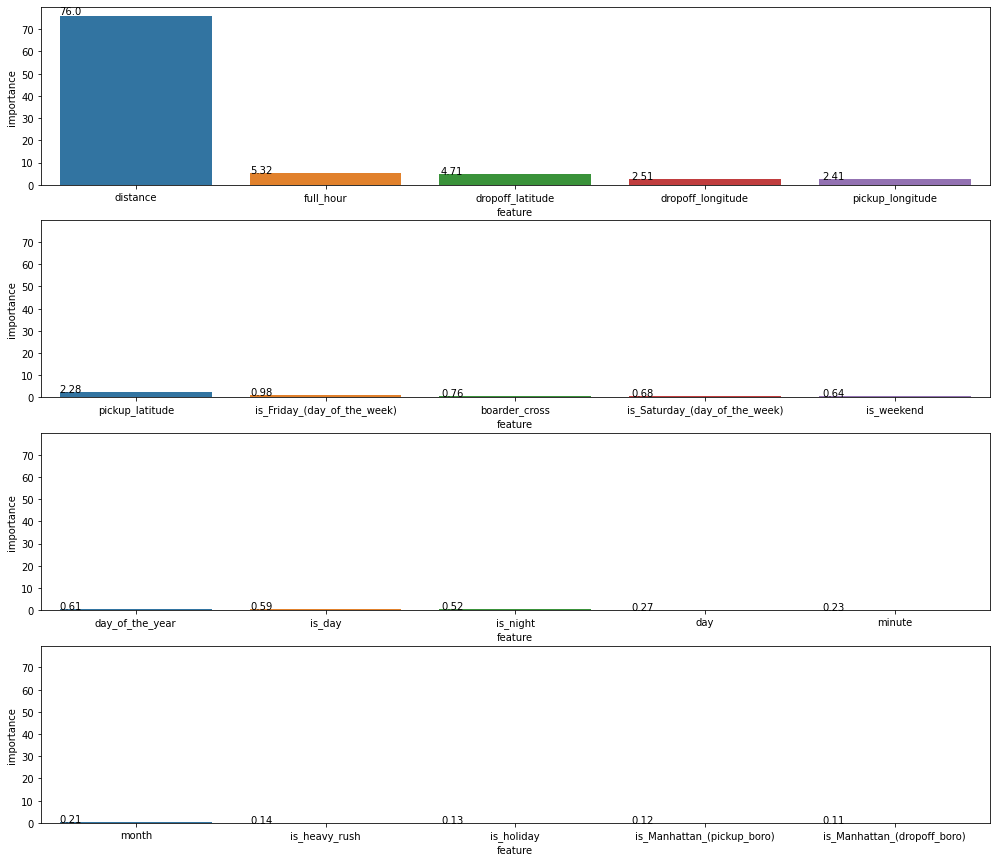

In [346]:
plot_importance(CatTaxi, cols)

## Prediction

In [347]:
test_pred = test.drop('id', axis = 1)

In [348]:
test_pred = test_pred.astype('float64')

In [349]:
test_pred

,boarder_cross,day,day_of_the_year,distance,dropoff_latitude,dropoff_longitude,from_outside,full_hour,is_1_(vendor_id),is_2_(vendor_id),is_Bronx_(dropoff_boro),is_Bronx_(pickup_boro),is_Brooklyn_(dropoff_boro),is_Brooklyn_(pickup_boro),is_Friday_(day_of_the_week),is_Manhattan_(dropoff_boro),is_Manhattan_(pickup_boro),is_Monday_(day_of_the_week),is_Queens_(dropoff_boro),is_Queens_(pickup_boro),is_Saturday_(day_of_the_week),is_Staten Island_(dropoff_boro),is_Staten Island_(pickup_boro),is_Sunday_(day_of_the_week),is_Thursday_(day_of_the_week),is_Tuesday_(day_of_the_week),is_Wednesday_(day_of_the_week),is_day,is_heavy_rush,is_holiday,is_night,is_other_(dropoff_boro),is_other_(pickup_boro),is_weekend,minute,month,passenger_count,pickup_latitude,pickup_longitude,store_and_fwd_flag,to_outside
625133,0.0,1.0,0.0,3.681598,40.769379,-73.969330,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,40.716881,-73.981850,0.0,0.0
625054,1.0,1.0,0.0,6.161401,40.769318,-73.879936,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,26.0,1.0,3.0,40.753963,-73.995621,0.0,0.0
623042,0.0,1.0,0.0,0.488983,40.779293,-73.944992,0.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,41.0,1.0,1.0,40.775925,-73.953194,0.0,0.0
622911,0.0,1.0,0.0,2.290393,40.762009,-73.979233,0.0,16.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,32.0,1.0,1.0,40.731640,-73.996849,0.0,0.0
625132,1.0,1.0,0.0,12.659995,40.891788,-73.854263,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,40.733562,-73.976501,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1927,0.0,30.0,181.0,3.786783,40.756248,-73.981087,0.0,13.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,6.0,1.0,40.705078,-74.007156,0.0,0.0
1928,0.0,30.0,181.0,0.645757,40.727165,-74.000130,0.0,13.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,6.0,1.0,40.730770,-73.988777,0.0,0.0
1929,0.0,30.0,181.0,0.463336,40.737534,-73.979912,0.0,13.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,6.0,1.0,40.730930,-73.981514,0.0,0.0
1921,0.0,30.0,181.0,1.020808,40.781738,-73.979073,0.0,13.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0,6.0,2.0,40.793430,-73.967148,0.0,0.0


In [350]:
test_pred = test_pred.to_numpy()

In [351]:
test_pred.shape

(625134, 41)

In [352]:
prediction = CatTaxi.predict(test_pred)

In [353]:
prediction = np.expm1(prediction)

In [354]:
prediction

array([1088.69723591, 1760.73063258,  182.85826737, ...,  274.46163384,
        374.51902834,  246.34355054])

In [355]:
prediction_df = pd.DataFrame()
prediction_df['id'] = test['id']
prediction_df['trip_duration'] = prediction.flatten()

In [356]:
round(prediction_df['trip_duration'].describe())

count    625134.0
mean        789.0
std         544.0
min         113.0
25%         400.0
50%         636.0
75%        1013.0
max        4098.0
Name: trip_duration, dtype: float64

In [357]:
csv = prediction_df.to_csv(
    '/Users/alexdrozdz/JupyterNotebook/New_York_City_Taxis/prediction.csv', index=False)

#### My outcome was better than results of 52% other people on private leaderboard. Score it's not quite impressive but it's only few submissions so I think that is good. I will continue this approach and commit changes. My RMSLE was 0.43230, best score on kaggle is 0.28976.